<a href="https://colab.research.google.com/github/L1KASA/Computational-Linguistics-NLP/blob/main/lab2/lab_2_6409_%D0%A2%D0%B0%D1%85%D0%BC%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%90%D0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Группа 6409, Тахмазова Анжелика

# Лабораторная работа №2

**Требования:**
* Python >= 3.X

В качестве входных данных к лабораторной работе взят широко известный набор данных IMDB, содержащий 50K обзоров фильмов ([imdb-dataset-of-50k-movie-reviews](https://disk.yandex.ru/i/DDb0zuyUmts5QA)). Откликами являются значения двух классов positive и negative.

In [1]:
import pandas as pd
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import string
import re
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import inflect
from google.colab import drive
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

nltk.download('stopwords')
nltk.download('gutenberg', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet')

drive.mount('/content/drive/')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive/


In [2]:
imdb_data = pd.read_csv('/content/drive/MyDrive/Dataset.csv')
imdb_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
imdb_data.shape

(50000, 2)

#### Шаг №1 Подготовка данных

Обязательно предобработайте данные!



In [4]:
def preprocess_text(text):

    # Инициализация лемматизатора
    lemmatizer = WordNetLemmatizer()

    # Инициализация регулярного выражения для удаления чисел
    number_pattern = re.compile(r'\b\d+\b')
    p = inflect.engine()

    # Приведение текста к нижнему регистру
    text = text.lower()

    # Удаление HTML-тегов
    text = re.sub(r'<[^>]+>', ' ', text)

    # Замена чисел на их текстовое представление
    text = re.sub(r'\b\d+\b', lambda x: p.number_to_words(x.group()), text)

    # Удаление знаков препинания и специальных символов
    text = re.sub(r'[\W_]', ' ', text)

    # Токенизация текста
    tokens = word_tokenize(text)

    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Лемматизация
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

text = "I've been out since 5, turning up. I'm wasting time, not enough!! :/"

preprocessed_text = preprocess_text(text)

print(preprocessed_text)

since five turning wasting time enough


In [5]:
imdb_data = imdb_data[:10000]
imdb_data.shape

(10000, 2)

In [6]:
# Применение предобработки к столбцу review
imdb_data['review'] = imdb_data['review'].apply(preprocess_text)
imdb_data['sentiment'] = imdb_data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Вывод первых пяти строк датасета
print(imdb_data.head())

                                              review  sentiment
0  one reviewer mentioned watching one oz episode...          1
1  wonderful little production filming technique ...          1
2  thought wonderful way spend time hot summer we...          1
3  basically family little boy jake think zombie ...          0
4  petter mattei love time money visually stunnin...          1


In [7]:
X = imdb_data['review']
y = imdb_data['sentiment']

# Разделение данных на обучающую и тестовую выборки (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train.head(5)

9254    want see film starring stan laurel laurel hard...
1561    watched snippet kid purchased blue underground...
1670    love film totally rock nicolas cage look hot t...
6087    despite critic ensue enjoyed immensely precise...
6669    mistaking halloween broadcast orson welles cla...
Name: review, dtype: object

In [9]:
y_train.head(5)

9254    1
1561    1
1670    1
6087    1
6669    1
Name: sentiment, dtype: int64

В качестве исследуемых способов представления текстов необходимо рассмотреть:

#### 1.Компоненты вектора: частоты ([CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)).

In [10]:
vectorizer = CountVectorizer()
x_CountVectorizer = vectorizer.fit_transform(X_train)

#### 2. Компоненты вектора: оценки tf-idf для слова ([TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)).

In [11]:
vectorizer = TfidfVectorizer()
x_TfidfVectorizer = vectorizer.fit_transform(X_train)

#### 3. Компоненты вектора: частоты N-грам.

In [12]:
vectorizer = CountVectorizer(ngram_range=(2, 2))
x_Ngram = vectorizer.fit_transform(X_train)

### Шаг 2. Исследование моделей

<table>
		<tr>
			<td></td>
			<td>$y = 1$</td>
			<td>$y = 0$</td>
		</tr>
		<tr>
			<td>$a(x) = 1$</td>
			<td>True Positive (TP)</td>
			<td>False Positive (FP)</td>
		</tr>
    	<tr>
			<td>$a(x) = 0$</td>
			<td>False Negative (FN)</td>
			<td>True Negative (TN)</td>
		</tr>
</table>

В зависимости от способа представления оценить качество классификации как долю правильных ответов на выборке ($\operatorname{accuracy} = \frac{\operatorname{TP} + \operatorname{TN}}{\operatorname{TP} + \operatorname{TN} + \operatorname{FP} + \operatorname{FN}}$). Используйте перекрестную проверку ([cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html), [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)).

Для каждого из нижеперечисленных моделей необходимо определить оптимальные гиперпараметры ([GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html))



In [13]:
# Создаем списки для сохранения результатов
svc_models = []  # Список для моделей SVC с оптимальными параметрами
rfc_models = []  # Список для моделей RandomForestClassifier с оптимальными параметрами

svc_accuracies = []
rfc_accuracies = []

X_data = [x_CountVectorizer, x_TfidfVectorizer, x_Ngram]

Качество классификации оцениваем для следующих моделей:

#### 1. Машина опорных векторов ([SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)).

In [14]:
# Определяем различные параметры для SVC
#parameters_svc = [
#    {'kernel': ['linear'], 'C': [1, 10]},  # Линейное ядро
#    {'kernel': ['rbf'], 'C': [1, 10]}, #, 'gamma': [1, 10]},  # RBF ядро
#    {'kernel': ['poly'], 'C': [1, 10]}, #, 'degree': [2, 5]}  # Полиномиальное ядро
#]

parameters_svc = {'kernel': ['linear', 'poly'], 'C': [1, 10]}

for X in X_data:
    # Инициализируем KFold для перекрестной проверки
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Инициализируем модель SVC
    svc = SVC()

    # Создаем объект GridSearchCV для подбора оптимальных параметров
    clf_svc = GridSearchCV(svc, parameters_svc, scoring='accuracy', cv=kf, verbose=3)

    # Обучаем модель на данных с помощью перекрестной проверки
    clf_svc.fit(X, y_train)

    # Сохраняем модель с оптимальными параметрами
    svc_models.append(clf_svc.best_estimator_)

    # Сохраняем точность модели SVC
    svc_accuracies.append(clf_svc.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ................C=1, kernel=linear;, score=0.839 total time=  22.3s
[CV 2/5] END ................C=1, kernel=linear;, score=0.818 total time=  22.7s
[CV 3/5] END ................C=1, kernel=linear;, score=0.844 total time=  26.7s
[CV 4/5] END ................C=1, kernel=linear;, score=0.853 total time=  22.9s
[CV 5/5] END ................C=1, kernel=linear;, score=0.844 total time=  24.0s
[CV 1/5] END ..................C=1, kernel=poly;, score=0.691 total time=  48.9s
[CV 2/5] END ..................C=1, kernel=poly;, score=0.642 total time=  47.2s
[CV 3/5] END ..................C=1, kernel=poly;, score=0.641 total time=  47.9s
[CV 4/5] END ..................C=1, kernel=poly;, score=0.618 total time=  47.6s
[CV 5/5] END ..................C=1, kernel=poly;, score=0.614 total time=  47.0s
[CV 1/5] END ...............C=10, kernel=linear;, score=0.839 total time=  22.6s
[CV 2/5] END ...............C=10, kernel=linear;,

#### 2. Случайный лес ([RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)).

In [15]:
# Определяем различные параметры для RandomForestClassifier
parameters_rfc = {
    'n_estimators': [10, 100, 200],  # Количество деревьев
    'max_depth': [1, 10],  # Максимальная глубина деревьев
}

for X in X_data:
    # Инициализируем KFold для перекрестной проверки
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Инициализируем модель RandomForestClassifier
    rfc = RandomForestClassifier()

    # Создаем объект GridSearchCV для подбора оптимальных параметров
    clf_rfc = GridSearchCV(rfc, parameters_rfc, scoring='accuracy', cv=kf, verbose=3)

    # Обучаем модель на данных с помощью перекрестной проверки
    clf_rfc.fit(X, y_train)

    # Сохраняем модель с оптимальными параметрами
    rfc_models.append(clf_rfc.best_estimator_)

    # Сохраняем точность модели SVC
    rfc_accuracies.append(clf_svc.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ......max_depth=1, n_estimators=10;, score=0.565 total time=   0.1s
[CV 2/5] END ......max_depth=1, n_estimators=10;, score=0.631 total time=   0.1s
[CV 3/5] END ......max_depth=1, n_estimators=10;, score=0.535 total time=   0.1s
[CV 4/5] END ......max_depth=1, n_estimators=10;, score=0.562 total time=   0.1s
[CV 5/5] END ......max_depth=1, n_estimators=10;, score=0.579 total time=   0.1s
[CV 1/5] END .....max_depth=1, n_estimators=100;, score=0.752 total time=   0.4s
[CV 2/5] END .....max_depth=1, n_estimators=100;, score=0.670 total time=   0.4s
[CV 3/5] END .....max_depth=1, n_estimators=100;, score=0.736 total time=   0.4s
[CV 4/5] END .....max_depth=1, n_estimators=100;, score=0.685 total time=   0.4s
[CV 5/5] END .....max_depth=1, n_estimators=100;, score=0.645 total time=   0.4s
[CV 1/5] END .....max_depth=1, n_estimators=200;, score=0.762 total time=   0.8s
[CV 2/5] END .....max_depth=1, n_estimators=200;,

### Шаг 3. Сравнение результатов

Сравнить точность обученных моделей. Найти наиболее точную.

In [16]:
# Модели и методы
models = ['SVC', 'RandomForestClassifier']
methods = ['CountVectorizer', 'TfidfVectorizer', 'Ngrams']

# mean для каждой модели и метода
mean_accuracies = {model: {method: [] for method in methods} for model in models}

# Заполнение mean
for i, model in enumerate(models):
    for j, method in enumerate(methods):
        # Определение точностей в зависимости от модели
        if model == 'SVC':
            accuracies = svc_accuracies
        elif model == 'RandomForestClassifier':
            accuracies = rfc_accuracies
        # Получение средней точности для текущей модели и метода
        mean_accuracies[model][method] = np.mean(accuracies)

# Вывод результатов
for model in models:
    print(f"Модель: {model}")
    for method, accuracy in mean_accuracies[model].items():
        print(f"{method}: {accuracy}")
    print()

Модель: SVC
CountVectorizer: 0.8412083333333333
TfidfVectorizer: 0.8412083333333333
Ngrams: 0.8412083333333333

Модель: RandomForestClassifier
CountVectorizer: 0.8133750000000001
TfidfVectorizer: 0.8133750000000001
Ngrams: 0.8133750000000001



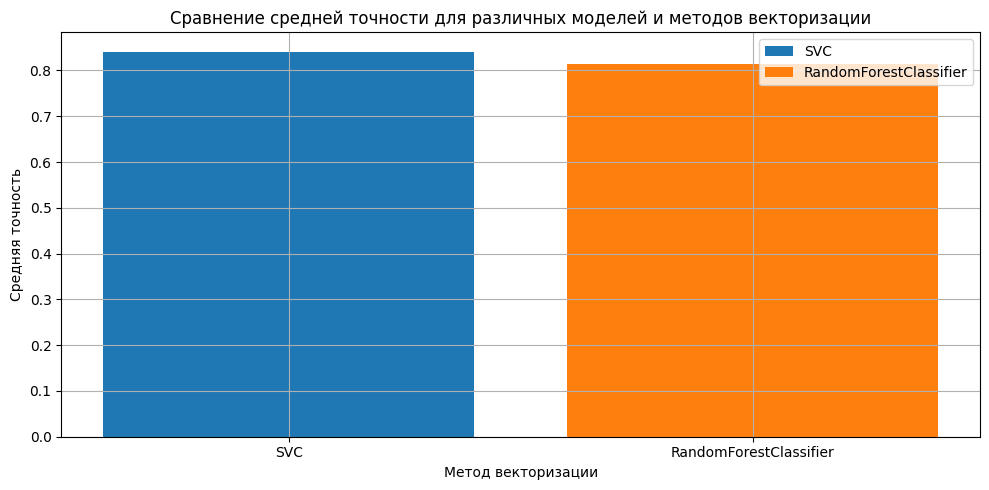

In [17]:
plt.figure(figsize=(10, 5))

# Для каждой модели и её точностей в средних значениях
for model, accuracies in mean_accuracies.items():
    # Создание столбчатой диаграммы
    plt.bar(model, accuracies.values(), label=model)

plt.xlabel('Метод векторизации')
plt.ylabel('Средняя точность')
plt.title('Сравнение средней точности для различных моделей и методов векторизации')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()